**Decision Tree Regressor:**

The Decision Tree Regressor is a non-linear supervised machine learning algorithm used for predicting continuous numerical values. It works by recursively splitting the dataset into smaller subsets based on feature values, forming a tree-like structure of decision rules. Each internal node represents a feature-based condition, and each leaf node represents a predicted value, typically the mean of the target values in that subset. Unlike linear models, Decision Trees do not assume a linear relationship between features and target, making them capable of capturing complex, non-linear patterns. They are easy to interpret and visualize, as the resulting tree clearly shows how decisions are made. However, they are prone to overfitting, especially on small datasets, so hyperparameter tuning (e.g., controlling tree depth or minimum samples per leaf) is important to improve generalization. Decision Trees can also serve as building blocks for more advanced ensemble models like Random Forests and Gradient Boosting, which often achieve better predictive performance.

In [3]:
!pip install smogn

**Setup and Library Imports:-This section sets up the environment for building a Decision Tree Regressor on the diabetes dataset. It includes importing essential Python libraries for data manipulation (numpy, pandas), visualization (matplotlib, seaborn), machine learning (scikit-learn), and imbalanced regression handling (smogn). A random seed is also defined to ensure reproducibility of results across experiments. **

In [4]:
#  imports & seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import smogn   # SMOTER / SMOGN implementation for regression (pip install smogn)
RANDOM_STATE = 42


**Load Dataset and Create DataFrame:-** In this step, the diabetes dataset from scikit-learn is loaded and converted into a pandas DataFrame for easier manipulation and analysis. The features (X) and target (y) are combined into a single DataFrame, allowing for convenient exploratory data analysis (EDA) and preprocessing.

In [5]:
# Load dataset and create DataFrame
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)   # names: ['age','sex','bmi','bp','s1',...]
y = pd.Series(data.target, name='target')
df = pd.concat([X, y], axis=1)
df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


**Exploratory Data Analysis – Basic Information:**

This step provides a quick overview of the dataset. Using df.info(), we check the number of samples, feature types, and missing values, while df.describe().T summarizes statistical properties like mean, standard deviation, min, max, and quartiles for each feature. This helps identify data quality issues and guides preprocessing and feature engineering.

In [6]:
# Basic info
print(df.info())
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
None


,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


In [7]:
# Missing values
print("Missing values per column:\n", df.isnull().sum())


Missing values per column:
 age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


**Exploratory Data Analysis – Target Distribution**

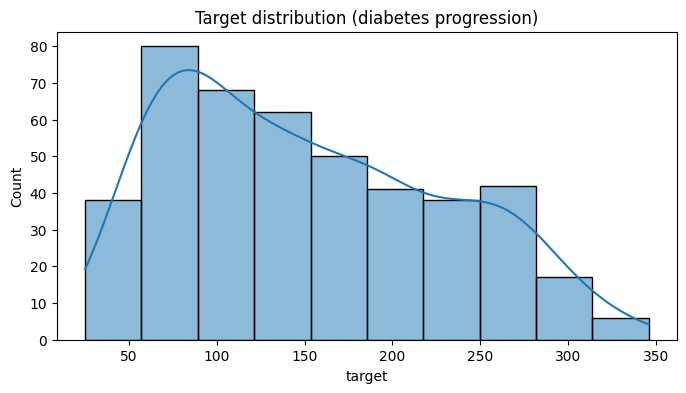

In [8]:
# Target distribution
plt.figure(figsize=(8,4))
sns.histplot(df['target'], kde=True)
plt.title("Target distribution (diabetes progression)")
plt.show()

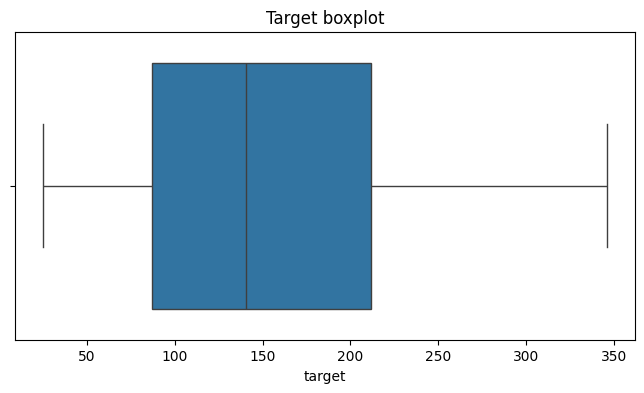

In [9]:
# Boxplot for target to inspect outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df['target'])
plt.title("Target boxplot")
plt.show()

**Correlation Heatmap:-**
This step visualizes the pairwise correlations between features and the target using a heatmap. By examining these correlations, we can identify strongly related features, detect potential multicollinearity, and guide feature selection or engineering decisions for the regression model.

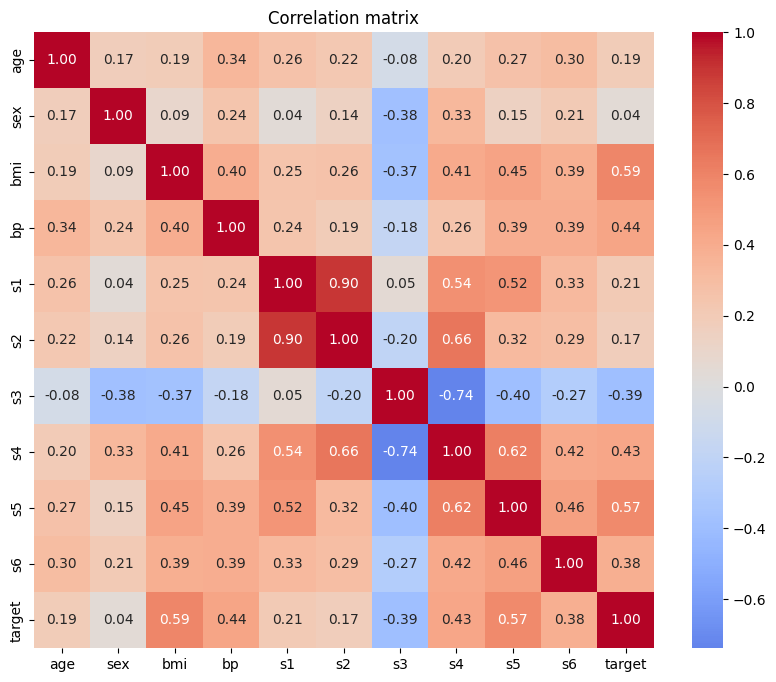

In [10]:
# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation matrix")
plt.show()

In [11]:
# Skewness (to decide transforms)
print("Skewness:\n", df.skew().sort_values(ascending=False))

Skewness:
 s3        0.799255
s4        0.735374
bmi       0.598148
target    0.440563
s2        0.436592
s1        0.378108
s5        0.291754
bp        0.290658
s6        0.207917
sex       0.127385
age      -0.231382
dtype: float64


**Pairwise Relationships of Top Features:- **This step visualizes the relationships between the top features most correlated with the target and the target variable itself using a pairplot. It helps to observe trends, patterns, and potential non-linear relationships, which can inform feature engineering and model selection decisions.

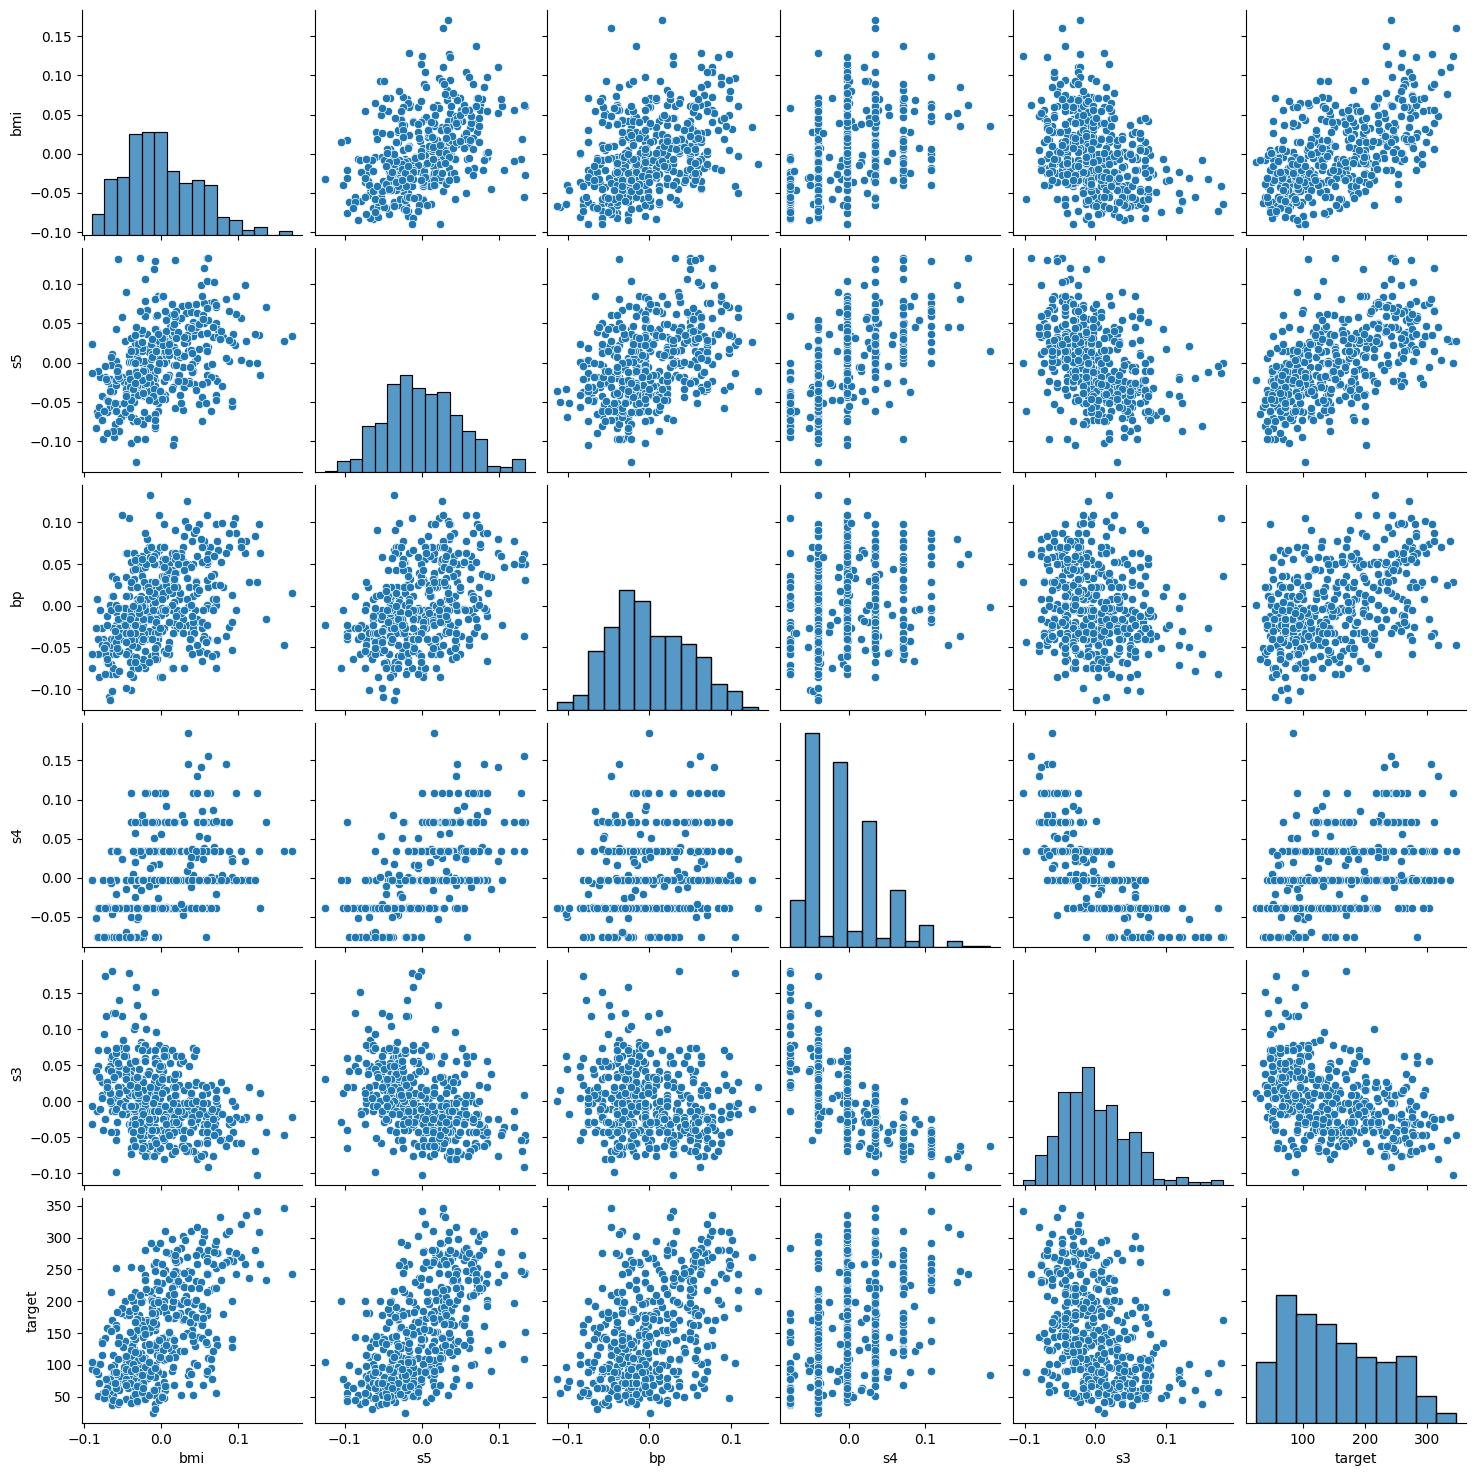

In [12]:

top_feats = corr['target'].abs().sort_values(ascending=False).index[1:6].tolist()
sns.pairplot(df[top_feats + ['target']])
plt.show()

**Feature engineering & preprocessing:-**

1.   Decision Tree doesn't need scaling, but we include scaling for compatibility if you later swap model.
2.   Create a couple of interaction features (example) and optionally polynomial features.



In [13]:
# Example feature engineering function
def add_features(df):
    df = df.copy()
    # Example interactions
    if 'bmi' in df.columns and 'bp' in df.columns:
        df['bmi_x_bp'] = df['bmi'] * df['bp']
    # Example ratio (be careful with zero-division; here features are continuous)
    df['bmi_div_age'] = df['bmi'] / (1 + np.abs(df['age']))
    return df

df_fe = add_features(df)
df_fe.shape


(442, 13)

In [14]:
feature_cols = [c for c in df_fe.columns if c != 'target']


In [15]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # scaler is optional for trees; kept for safe swapping
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, feature_cols)
])


**Train-Test Split** In this step, the dataset is split into training and testing sets using an 80-20 ratio. The training set is used to train the Decision Tree Regressor, while the testing set is kept aside for evaluating the model’s performance on unseen data. Separating features (X) and target (y) ensures proper input for modeling and avoids data leakage.

In [16]:
train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=RANDOM_STATE)
X_train = train_df[feature_cols].copy()
y_train = train_df['target'].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df['target'].copy()


In [17]:
# Skip smogn and use original training data since the target is not imbalanced
X_train_res = X_train
y_train_res = y_train

print("Original train shape:", X_train.shape)
print("Resampled train shape:", X_train_res.shape)

Original train shape: (353, 12)
Resampled train shape: (353, 12)


**Model Pipeline and Hyperparameter Tuning**

This step builds a machine learning pipeline combining preprocessing, feature selection, and a Decision Tree Regressor. SelectKBest is used to retain the most relevant features based on their correlation with the target. Hyperparameters of the tree (like max_depth, min_samples_leaf, and max_features) are optimized using GridSearchCV with 5-fold cross-validation, minimizing root mean squared error (RMSE). The output shows the best combination of hyperparameters and the corresponding cross-validated RMSE, ensuring the model is both accurate and generalizes well to unseen data.

In [18]:
pipe = Pipeline([
    ('preproc', preprocessor),
    ('selector', SelectKBest(score_func=f_regression, k=10)),   # optional selection
    ('reg', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = {
    'reg__max_depth': [3, 5, 8, None],
    'reg__min_samples_split': [2, 5, 10, 20],
    'reg__min_samples_leaf': [1, 2, 5, 10],
    'reg__max_features': [None, 'sqrt', 0.8]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train_res, y_train_res)    # fit on resampled training data
print("Best params:", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params: {'reg__max_depth': 5, 'reg__max_features': 0.8, 'reg__min_samples_leaf': 10, 'reg__min_samples_split': 2}
Best CV RMSE: 63.04321074376967


**Evaluate on the holdout test set**

Test RMSE: 62.174, MAE: 48.796, R2: 0.270


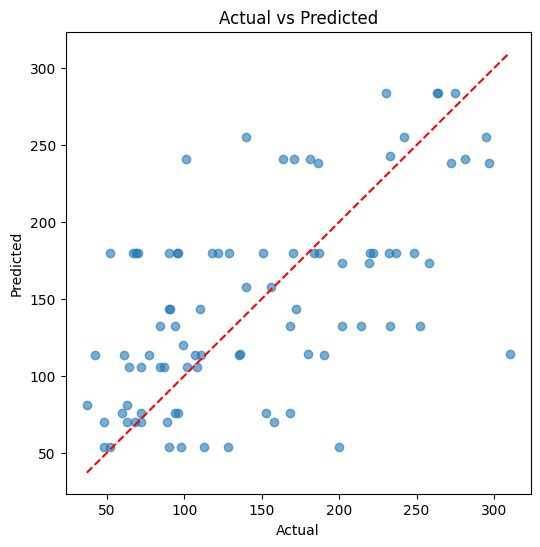

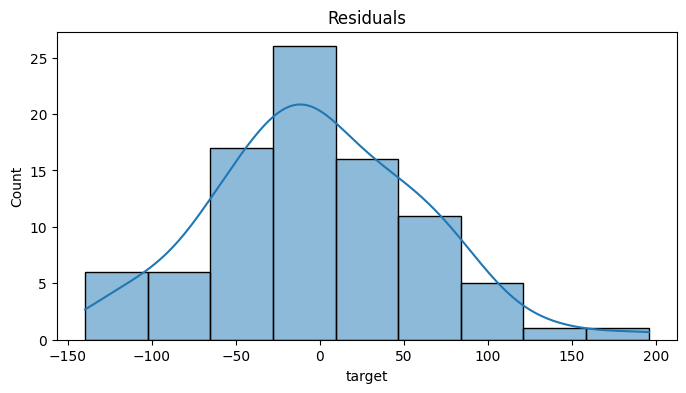

In [19]:
best = gs.best_estimator_
y_pred = best.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# Diagnostic plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# Residuals
resid = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(resid, kde=True)
plt.title("Residuals")
plt.show()

**Feature importance & explainability** This step extracts and visualizes the importance of each feature in the trained Decision Tree Regressor. After preprocessing and feature selection, the feature_importances_ attribute of the tree is used to rank features based on how much they contribute to reducing prediction error. The resulting bar plot highlights the most influential features, providing insight into which variables are driving the model’s predictions and supporting interpretability for the regression task.

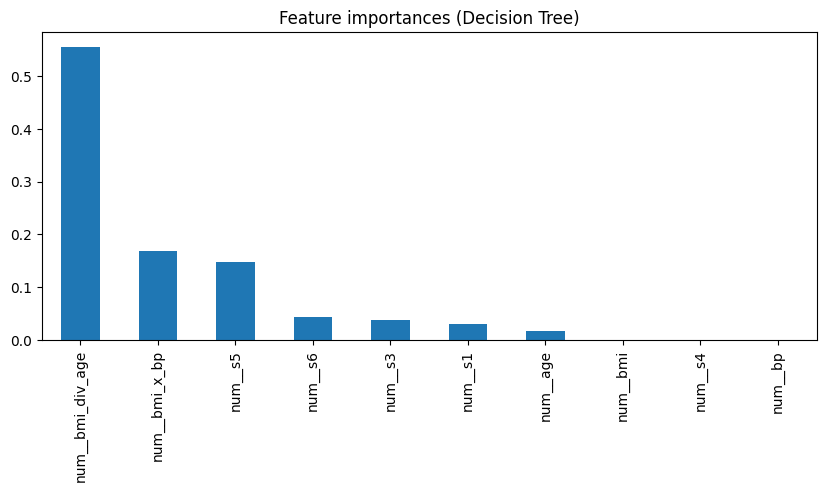

In [20]:
# If reg is DecisionTreeRegressor inside the pipeline:
reg = best.named_steps['reg']

# Get feature names after preprocessing and selection:
preproc = best.named_steps['preproc']
selector = best.named_steps['selector']

# Get the features names after preprocessing
preprocessed_feature_names = preproc.get_feature_names_out(feature_cols)

# Get the names of the selected features
selected_feature_names = preprocessed_feature_names[selector.get_support()]

importances = reg.feature_importances_

fi = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)
fi.plot(kind='bar', figsize=(10,4))
plt.title("Feature importances (Decision Tree)")
plt.show()

**Saving the Model and Artifacts**

In [21]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(best, "models/dt_regressor.joblib")
# Save figures (matplotlib .png) from EDA to /reports/figures for README

['models/dt_regressor.joblib']